In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import AmazonProducts
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
torch.cuda.is_available()

True

In [3]:
dataset = AmazonProducts(root='AmazonProducts')

In [5]:
data = dataset[0]

In [6]:
data

Data(x=[1569960, 200], edge_index=[2, 264339468], y=[1569960, 107], train_mask=[1569960], val_mask=[1569960], test_mask=[1569960])

In [8]:
data.num_nodes

1569960

In [9]:
subset_nodes = list(range(1000))
subset_edge_index = data.edge_index[:, (data.edge_index[0] < 1000) & (data.edge_index[1] < 1000)]

In [10]:
subset_nodes = list(range(1000))
subset_edge_index = data.edge_index[:, (data.edge_index[0] < 1000) & (data.edge_index[1] < 1000)]

In [12]:
subset_data = Data(x=data.x[subset_nodes], edge_index=subset_edge_index, y=data.y[subset_nodes])

In [13]:
G_sub = to_networkx(subset_data, to_undirected=True)

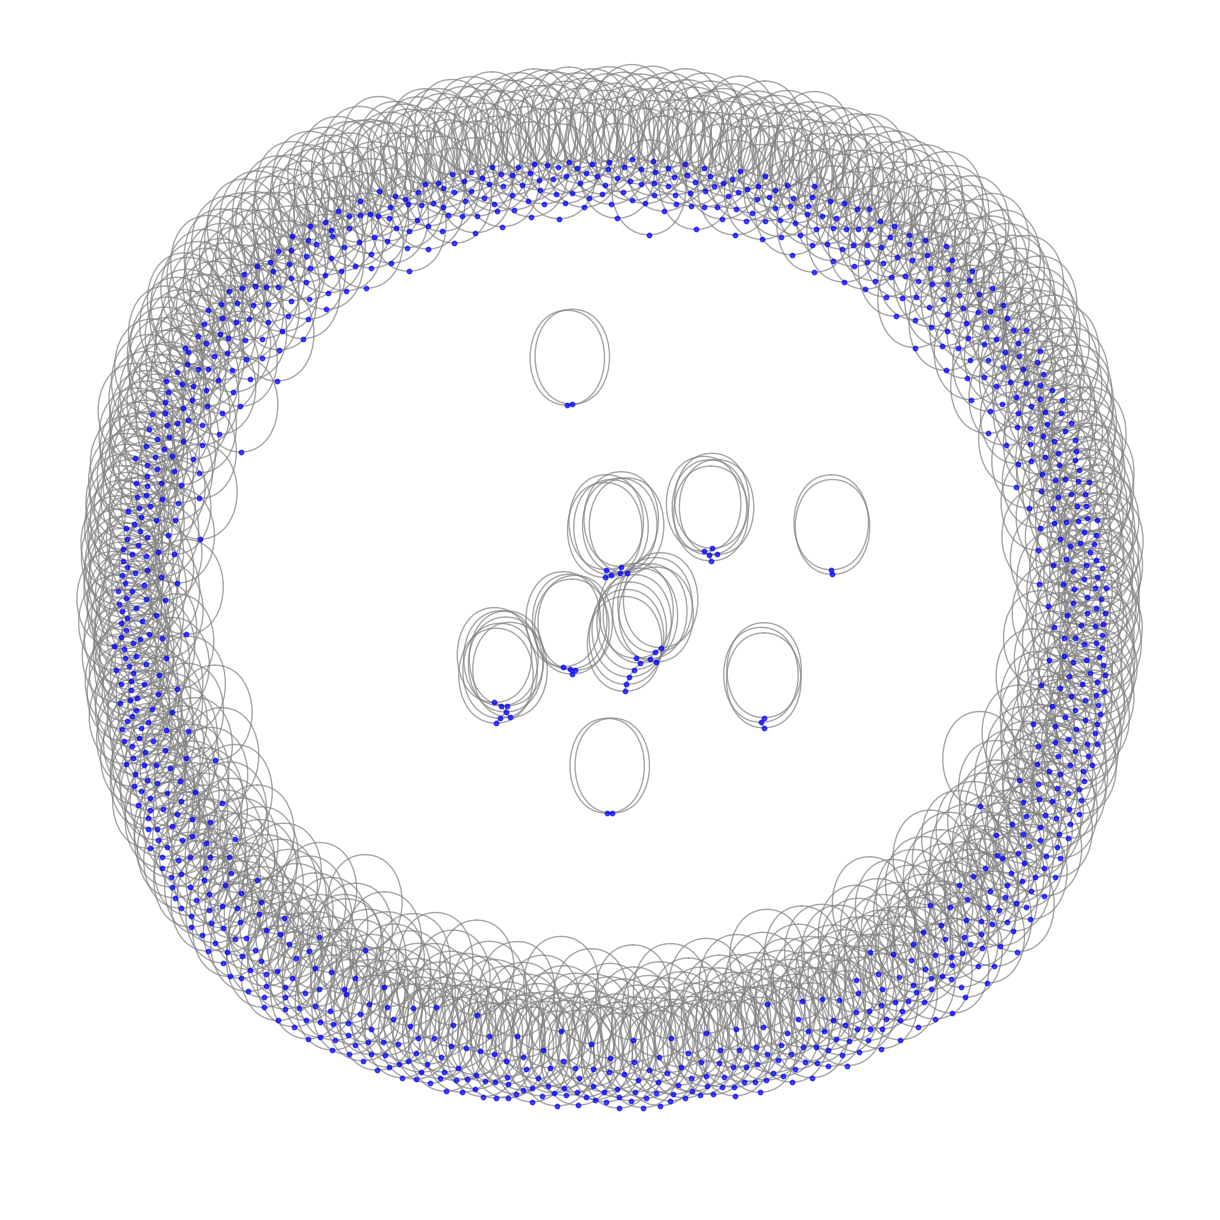

In [14]:
plt.figure(figsize=(12, 12))

# Use a layout for positioning the nodes (spring layout is commonly used)
pos = nx.spring_layout(G_sub, seed=42)

# Draw the graph
nx.draw(G_sub, pos, with_labels=False, node_size=10, node_color="blue", edge_color="grey", alpha=0.7)

# Show the plot
plt.show()

In [15]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features per node: {data.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Graph: {data}')

Number of nodes: 1569960
Number of edges: 264339468
Number of features per node: 200
Number of classes: 107
Graph: Data(x=[1569960, 200], edge_index=[2, 264339468], y=[1569960, 107], train_mask=[1569960], val_mask=[1569960], test_mask=[1569960])


In [16]:
# Inspect node features
print('Node features shape:', data.x.shape)
print('First node features:', data.x[0])

# Inspect edge index
print('Edge index shape:', data.edge_index.shape)
print('First 10 edges:', data.edge_index[:, :10])

# Inspect labels
print('Labels shape:', data.y.shape)
print('First 10 labels:', data.y[:10])

# Check train, validation, and test masks
print('Train mask:', data.train_mask.sum().item(), 'nodes')
print('Validation mask:', data.val_mask.sum().item(), 'nodes')
print('Test mask:', data.test_mask.sum().item(), 'nodes')


Node features shape: torch.Size([1569960, 200])
First node features: tensor([-1.4657e-01,  2.2256e-01, -3.5967e-01,  1.5098e-01, -7.1912e-02,
        -2.3552e-01, -3.9956e-01,  2.4807e-01, -3.0449e-01,  6.4564e-01,
        -1.3016e-01, -1.3443e-02,  3.5432e-01,  1.4126e-02, -1.0177e-01,
         1.4744e-02,  6.3098e-01,  2.7300e-04,  9.6278e-02,  1.0879e-02,
        -3.0750e-01, -4.9615e-01, -1.1276e-01, -9.7032e-02,  1.5852e-02,
         2.9825e-01,  1.6043e-02,  3.3084e-01,  2.3977e-01,  4.3576e-01,
        -2.3979e-01,  2.1794e-01,  6.8402e-02,  7.3455e-02, -5.0774e-02,
        -4.3512e-01,  4.3131e-02, -1.9217e-01,  5.3299e-03, -1.5593e-02,
         2.8923e-01, -8.8703e-02,  2.5056e-01, -1.7714e-01,  1.0435e-01,
        -3.9434e-01,  2.4477e-01, -1.3295e-01,  9.5665e-02,  2.8370e-01,
         1.8697e-01,  4.4272e-03,  8.5938e-02, -9.8225e-02,  3.3373e-01,
         1.6169e-01,  5.7122e-02, -1.2580e-01, -2.6470e-01,  2.3611e-01,
        -4.0477e-01,  1.7691e-01,  8.8234e-02,  2.2035e

In [17]:
import torch
from torch_geometric.data import Data, NeighborSampler
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.loader import GraphSAINTNodeSampler, GraphSAINTEdgeSampler, GraphSAINTRandomWalkSampler

# Define the GCN model
class GraphSAINT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAINT, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model, optimizer, and data
model = GraphSAINT(data.num_node_features, 128, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Sampling method
sampler = GraphSAINTRandomWalkSampler(data, batch_size=6000, walk_length=2, num_steps=5, sample_coverage=0, save_dir=None)

# Training loop
def train():
    model.train()
    for batch_data in sampler:
        optimizer.zero_grad()
        batch_data = batch_data.to('cuda')
        out = model(batch_data.x, batch_data.edge_index)
        loss = F.nll_loss(out[batch_data.train_mask], batch_data.y[batch_data.train_mask])
        loss.backward()
        optimizer.step()

# Evaluate the model
def test():
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
    return acc

# Training and evaluation
for epoch in range(1, 201):
    train()
    acc = test()
    print(f'Epoch: {epoch}, Test Accuracy: {acc:.4f}')


ImportError: 'SparseTensor' requires 'torch-sparse'

In [7]:
G = to_networkx(data[:500], to_undirected=True)

TypeError: unhashable type: 'slice'